L'**Uniform Crime Reporting** (UCR) est un programme du FBI dont le but est de collecter et publier des statistiques sur la criminalité aux États-Unis depuis 1930. Notre dataset `CrimeStatebyState.csv` résume les données qui ont été collectée entre **1960** et **2014**.

Le but de ce TP est de comprendre et d'estimer l'évolution de la criminalité aux États-Unis. Il consiste entre autre à :
1. Traiter et nettoyer les données;
2. Les explorer/visualiser;
3. Identifier des profils types de criminalité;
4. Estimer l'évolution de la criminalité.

## Découverte des données

Commençons par voir à quoi ressemble le fichier `CrimeStatebyState.csv` qui nous sert actuellement de dataset.

In [ ]:
with open('CrimeStatebyState.csv', mode='r') as f:
    for i in range(15):
        print(f.readline())

Uniform Crime Reporting Statistics - UCR Data Online

http://www.ucrdatatool.gov/



Estimated crime in Alabama



,,National or state crime,,,,,,,,,,"Crime rate per 100,000 population",,,,,,,,,,,



,,Violent crime,,,,,,Property crime,,,,Violent crime,,,,,,Property crime,,,,,



Year,Population,Violent crime total,Murder and nonnegligent Manslaughter,Legacy rape /1,Revised rape /2,Robbery,Aggravated assault,Property crime total,Burglary,Larceny-theft,Motor vehicle theft,Violent Crime rate,Murder and nonnegligent manslaughter rate,Legacy rape rate /1,Revised rape rate /2,Robbery rate,Aggravated assault rate,Property crime rate,Burglary rate,Larceny-theft rate,Motor vehicle theft rate,

1960,   3266740,       6097,         406,         281,,         898,       4512,      33823,      11626,      19344,       2853,         186.6,          12.4,           8.6,,          27.5,         138.1,       1035.4,         355.9,         592.1,          87.3 

1961,   3302000,       5564,         427

Comme on peut le constater, le formattage du fichier n'est pas ce à quoi s'attend d'habitude. Voici quelques points qu'on peut constater :
* Les quelques premières lignes du fichier sont inutiles pour l'analyse
* Les données en elle-même sont **écrites état par état** (cf. la mention `Estimated crime in Alabama`), on devra **fusionner toutes ces séries ensemble** en rajoutant une colonne `etat` par exemple.
* Bien que ce soit difficilement lisible dans le fichier CSV, les **en-têtes sont à 3 niveaux** :
    * Niveau 0 : Effectifs recensés, taux de prévalence (pour 100 000 hab, en fonction de la population de l'année courante)
    * Niveau 1 : Crimes et Délits concernant la propriété (vols, etc...)
    * Niveau 2 : En-tête les plus précis, définissant le nom des variables utilisées dans le tableau de donnée
    
Pour recréer cet en-tête hiérarchique dans `pandas` il suffirait de passer une liste de lignes à lire au paramètre `header` de `read_csv`.

----

Afin de pouvoir extraire une série de données par état, il est nécessaire d'isoler chaque bloc de données. On remarque que tous ces blocs commencent par `Estimated crime in `, on va donc séparer les données brutes selon ce texte.

## Préparation et néttoyage des données (Phase 1)

In [ ]:
# On commence par lire tout le fichier dans une seule chaîne de caractères
with open('CrimeStatebyState.csv', mode='r') as f:
    raw_data = f.read()

# Séparation et isolation des blocs de données
# Le premier élément isolé est le texte au début qui ne contient pas de données, on l'ignore donc
data_blocks = raw_data.split('Estimated crime in ')[1:]
len(data_blocks)

51

Les données sont enregistrées pour les 50 états des USA ainsi que le district fédéral de Columbia où se trouve la capitale Washington, soit 51 blocs de données.

Pour chaque bloc de donnée, la première ligne est constitué du nom de l'état, suivi des caractères `\n\n` (deux sauts de lignes). En cherchant dans la documentation Python pour les [méthodes sur les string](https://docs.python.org/3/library/stdtypes.html#str.partition), nous trouvons une fonction `partition` qui accepte en entrée une chaîne de caractère et un séparateur, et en sortie un tuple contenant :
* la portion de texte à gauche de la **première** occurence du séparateur
* le séparateur lui-même
* puis la portion restante de texte à droite du séparateur.

*Nous profiterons pour associer chaque états à ses données.*

In [ ]:
data_dict = dict()

for block in data_blocks:
    state, _ , data = block.partition('\n\n')
    data_dict[state] = data

data_dict['California']

',,National or state crime,,,,,,,,,,"Crime rate per 100,000 population",,,,,,,,,,,\n\n,,Violent crime,,,,,,Property crime,,,,Violent crime,,,,,,Property crime,,,,,\n\nYear,Population,Violent crime total,Murder and nonnegligent Manslaughter,Legacy rape /1,Revised rape /2,Robbery,Aggravated assault,Property crime total,Burglary,Larceny-theft,Motor vehicle theft,Violent Crime rate,Murder and nonnegligent manslaughter rate,Legacy rape rate /1,Revised rape rate /2,Robbery rate,Aggravated assault rate,Property crime rate,Burglary rate,Larceny-theft rate,Motor vehicle theft rate,\n1960,  15717204,      37558,         616,       2859,,      15287,      18796,     508511,     143102,     311956,      53453,         239.0,           3.9,          18.2,,          97.3,         119.6,       3235.4,         910.5,       1984.8,         340.1 \n1961,  16397000,      38154,         605,       3033,,      14832,      19684,     521008,     146615,     319834,      54559,         232.7,           3.7, 

On peut désormais lire chacune de ces séries de données dans un DataFrame avant de concaténer ces 51 DataFrame dans un unique DataFrame.

**Petite remarque technique** : la fonction `read_csv` accepte en entrée une chaîne de caractères représentant un nom de fichier ou un objet se comportant comme un fichier ouvert (par exemple avec la fonction `open` vue ci-dessus). Les données sont dans notre cas uniquement en mémoire, nous avons donc deux choix :
* Ecrire chaque série (une par état) dans un fichier (temporaire ou non) puis lire chaque fichier avec `pandas`
* Créer un objet **en mémoire** se comportant comme un fichier et le lire avec `pandas`

On choisit la deuxième option pour éviter de polluer le dossier avec 51 fichiers supplémentaires. La cellule suivante effectue la création (avec la classe `StringIO`) puis la lecture et la transformation des données. La création de variables se comportant comme des fichiers en Python n'est pas fondamentalement nécessaire à retenir, elle constitue juste un raccourci pratique ici.

In [ ]:
from io import StringIO
import pandas as pd

df_list = list()

for state, data in data_dict.items():
    buffer = StringIO(data) # création d'un objet se comportant comme un fichier mais uniquement en mémoire
    df = pd.read_csv(buffer,
                     header=2, # on ne conserve que le dernier niveau pour les en-têtes
                     index_col='Year')

    df['state'] = state # Ajout d'une variable qualitative "state" pour identifier les séries après concaténation
    df_list.append(df)

df_list[0].head()

,Population,Violent crime total,Murder and nonnegligent Manslaughter,Legacy rape /1,Revised rape /2,Robbery,Aggravated assault,Property crime total,Burglary,Larceny-theft,...,Legacy rape rate /1,Revised rape rate /2,Robbery rate,Aggravated assault rate,Property crime rate,Burglary rate,Larceny-theft rate,Motor vehicle theft rate,Unnamed: 22,state
Year,,,,,,,,,,,,,,,,,,,,,
1960,3266740,6097,406,281,NaN,898,4512,33823,11626,19344,...,8.6,NaN,27.5,138.1,1035.4,355.9,592.1,87.3,NaN,Alabama
1961,3302000,5564,427,252,NaN,630,4255,32541,11205,18801,...,7.6,NaN,19.1,128.9,985.5,339.3,569.4,76.8,NaN,Alabama
1962,3358000,5283,316,218,NaN,754,3995,35829,11722,21306,...,6.5,NaN,22.5,119.0,1067.0,349.1,634.5,83.4,NaN,Alabama
1963,3347000,6115,340,192,NaN,828,4755,38521,12614,22874,...,5.7,NaN,24.7,142.1,1150.9,376.9,683.4,90.6,NaN,Alabama
1964,3407000,7260,316,397,NaN,992,5555,46290,15898,26713,...,11.7,NaN,29.1,163.0,1358.7,466.6,784.1,108.0,NaN,Alabama


In [ ]:
# Concaténation des DataFrame
df = pd.concat(df_list)

print(df.state.unique())
print(len(df), 'lignes au total')
df.head()

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']
2866 lignes au total


,Population,Violent crime total,Murder and nonnegligent Manslaughter,Legacy rape /1,Revised rape /2,Robbery,Aggravated assault,Property crime total,Burglary,Larceny-theft,...,Legacy rape rate /1,Revised rape rate /2,Robbery rate,Aggravated assault rate,Property crime rate,Burglary rate,Larceny-theft rate,Motor vehicle theft rate,Unnamed: 22,state
Year,,,,,,,,,,,,,,,,,,,,,
1960,3266740,6097,406.0,281.0,NaN,898.0,4512.0,33823.0,11626.0,19344.0,...,8.6,NaN,27.5,138.1,1035.4,355.9,592.1,87.3,NaN,Alabama
1961,3302000,5564,427.0,252.0,NaN,630.0,4255.0,32541.0,11205.0,18801.0,...,7.6,NaN,19.1,128.9,985.5,339.3,569.4,76.8,NaN,Alabama
1962,3358000,5283,316.0,218.0,NaN,754.0,3995.0,35829.0,11722.0,21306.0,...,6.5,NaN,22.5,119.0,1067.0,349.1,634.5,83.4,NaN,Alabama
1963,3347000,6115,340.0,192.0,NaN,828.0,4755.0,38521.0,12614.0,22874.0,...,5.7,NaN,24.7,142.1,1150.9,376.9,683.4,90.6,NaN,Alabama
1964,3407000,7260,316.0,397.0,NaN,992.0,5555.0,46290.0,15898.0,26713.0,...,11.7,NaN,29.1,163.0,1358.7,466.6,784.1,108.0,NaN,Alabama


Enfin, les différentes catégories de crimes et délits recensés sont :
* `Violent crime total` : inclut tous les crimes avec violence, y compris ceux chiffrés ci-dessous
* `Murder and nonnegligent manslaughter` : meurtre et homicide volontaire (ne comprend pas les accidents de la route)
* `Legacy rape / Revised rape` : viol (effectifs comptabilisés pour les définitions historique et révisée)
* `Robbery` : Vol avec aggression (à main armée par exemple)
* `Aggravated Assault` : Agression caractérisée, avec intention d'infliger des blessures
* `Property crime total` : inclus tous les crimes relatifs à la propriété, y compris ceux chiffrés ci-dessous
* `Burglary` : cambriolage (effraction de la propriété)
* `Larceny-theft` : vols en tout genre, non violents
* `Motor vehicle theft` : vols de véhicules en tout genre (sauf avions, trains et matériels agricoles)

## Préparation et néttoyage des données (Phase 2)

* Eliminer les effectifs totaux absolus et **ne garder que les taux (*rates*)** plus facilement comparables entre les années et les états
* Passage de l'index à un index temporel, de 1960 à 2014
* Conversion de la colonne `state` vers un type qualitatif (`category`)
* Renommer toutes les colonnes avec des noms courts et explicites
* Fusionner intelligemment les séries `Legacy rape` et `Revised rape` en une unique série `Rape`. En regardant les [définitions](https://www.ucrdatatool.gov/offenses.cfm) en détail, nous découvrons que `Revised Rape` est une définition plus généraliste que `Legacy Rape` (et donc le taux de `Revised Rape` est toujours supérieur ou égal au taux de `Legacy Rape`). Aussi, pour les années où l'information `Revised Rape` est disponible, nous retiendrons ce chiffre, sinon nous retiendrons `Legacy Rape` (toujours disponible).
* Supprimer la colonne ne contenant que des NaN
* Vérifier la présence de NaN restants

In [ ]:
# On sélectionne les colonnes contenant le mot "rate", ainsi que les colonnes "Population" et "state"
selected_columns = df.columns[df.columns.str.contains('rate') | (df.columns == 'Population') | (df.columns == 'state')]
df = df[selected_columns]
df.head()

,Population,Violent Crime rate,Murder and nonnegligent manslaughter rate,Legacy rape rate /1,Revised rape rate /2,Robbery rate,Aggravated assault rate,Property crime rate,Burglary rate,Larceny-theft rate,Motor vehicle theft rate,state
Year,,,,,,,,,,,,
1960,3266740,186.6,12.4,8.6,NaN,27.5,138.1,1035.4,355.9,592.1,87.3,Alabama
1961,3302000,168.5,12.9,7.6,NaN,19.1,128.9,985.5,339.3,569.4,76.8,Alabama
1962,3358000,157.3,9.4,6.5,NaN,22.5,119.0,1067.0,349.1,634.5,83.4,Alabama
1963,3347000,182.7,10.2,5.7,NaN,24.7,142.1,1150.9,376.9,683.4,90.6,Alabama
1964,3407000,213.1,9.3,11.7,NaN,29.1,163.0,1358.7,466.6,784.1,108.0,Alabama


In [ ]:
# Renommage des colonnes

df = df.rename(columns={
    'Population': 'population',
    'Violent Crime rate': 'violent_crime_total',
    'Murder and nonnegligent manslaughter rate': 'murder',
    'Legacy rape rate /1': 'legacy_rape',
    'Revised rape rate /2': 'revised_rape',
    'Robbery rate': 'robbery',
    'Aggravated assault rate': 'assault',
    'Property crime rate': 'property_crime_total',
    'Burglary rate': 'burglary',
    'Larceny-theft rate': 'theft',
    'Motor vehicle theft rate': 'car_theft'
})

df.head()

,population,violent_crime_total,murder,legacy_rape,revised_rape,robbery,assault,property_crime_total,burglary,theft,car_theft,state
Year,,,,,,,,,,,,
1960,3266740,186.6,12.4,8.6,NaN,27.5,138.1,1035.4,355.9,592.1,87.3,Alabama
1961,3302000,168.5,12.9,7.6,NaN,19.1,128.9,985.5,339.3,569.4,76.8,Alabama
1962,3358000,157.3,9.4,6.5,NaN,22.5,119.0,1067.0,349.1,634.5,83.4,Alabama
1963,3347000,182.7,10.2,5.7,NaN,24.7,142.1,1150.9,376.9,683.4,90.6,Alabama
1964,3407000,213.1,9.3,11.7,NaN,29.1,163.0,1358.7,466.6,784.1,108.0,Alabama


In [ ]:
# Conversion de l'index (Year) vers un type temporel
# Si un champ ne peut pas être converti, il est modifié en NaT (Not a Time)
df.index = pd.to_datetime(df.index, format='%Y', errors='coerce')

df[df.index.isna()]

,population,violent_crime_total,murder,legacy_rape,revised_rape,robbery,assault,property_crime_total,burglary,theft,car_theft,state
Year,,,,,,,,,,,,
NaT,1. The figures shown in this column for the of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wyoming
NaT,2. The figures shown in this column for the of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wyoming
NaT,Notes:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wyoming
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wyoming
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wyoming
...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wyoming
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wyoming
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wyoming


In [ ]:
# Suppression des lignes avec un index NaT
df = df[df.index.notna()]

En vertu de sa définition plus généraliste, on a toujours `revised_rape` >= `legacy_rape` .On peut donc rapidement fusionner les deux séries en prenant le max ligne par ligne. Les NaN sont automatiquement ignorés

In [ ]:
# Fusion des séries "legacy_rape" et "revised_rape" en une série "rape"
df['rape'] = df[['revised_rape', 'legacy_rape']].max(axis=1, skipna=True)
df = df.drop(columns=['legacy_rape', 'revised_rape'])
df.head()

,population,violent_crime_total,murder,robbery,assault,property_crime_total,burglary,theft,car_theft,state,rape
Year,,,,,,,,,,,
1960-01-01,3266740,186.6,12.4,27.5,138.1,1035.4,355.9,592.1,87.3,Alabama,8.6
1961-01-01,3302000,168.5,12.9,19.1,128.9,985.5,339.3,569.4,76.8,Alabama,7.6
1962-01-01,3358000,157.3,9.4,22.5,119.0,1067.0,349.1,634.5,83.4,Alabama,6.5
1963-01-01,3347000,182.7,10.2,24.7,142.1,1150.9,376.9,683.4,90.6,Alabama,5.7
1964-01-01,3407000,213.1,9.3,29.1,163.0,1358.7,466.6,784.1,108.0,Alabama,11.7


In [ ]:
###### Correction des types de données (`state` vers `category`, `population` vers un entier)
df = df.astype({'population': 'int', 'state': 'category'})
df.dtypes

,0
population,int64
violent_crime_total,float64
murder,float64
robbery,float64
assault,float64
property_crime_total,float64
burglary,float64
theft,float64
car_theft,float64
state,category


Vérification des NaN restants

In [ ]:
df.isna().sum(axis=0)

,0
population,0
violent_crime_total,0
murder,0
robbery,0
assault,0
property_crime_total,0
burglary,0
theft,0
car_theft,0
state,0


In [ ]:
df.to_csv('crime_transformed.csv')

## Exploration des données

In [ ]:
import plotly.express as px

In [ ]:
df.head()

,population,violent_crime_total,murder,robbery,assault,property_crime_total,burglary,theft,car_theft,state,rape
Year,,,,,,,,,,,
1960-01-01,3266740,186.6,12.4,27.5,138.1,1035.4,355.9,592.1,87.3,Alabama,8.6
1961-01-01,3302000,168.5,12.9,19.1,128.9,985.5,339.3,569.4,76.8,Alabama,7.6
1962-01-01,3358000,157.3,9.4,22.5,119.0,1067.0,349.1,634.5,83.4,Alabama,6.5
1963-01-01,3347000,182.7,10.2,24.7,142.1,1150.9,376.9,683.4,90.6,Alabama,5.7
1964-01-01,3407000,213.1,9.3,29.1,163.0,1358.7,466.6,784.1,108.0,Alabama,11.7


In [ ]:
# Création d'une variable qualitative indiquant le type de criminalité à l'aide de melt
# N'hésitez pas à décomposer cette cellule en plusieurs étapes pour mieux comprendre les transformations
tidy_df =(df
          .reset_index()
          .melt(id_vars='Year',
                value_vars=['violent_crime_total', 'property_crime_total'],
                var_name='crime_type',
                value_name='crime_rate')
          .groupby(['Year', 'crime_type']).agg(std_value=('crime_rate', 'std'),
                                               mean_value=('crime_rate', 'mean'))
          .reset_index()
         )

tidy_df.head()

,Year,crime_type,std_value,mean_value
0,1960-01-01,property_crime_total,640.111698,1604.480
1,1960-01-01,violent_crime_total,96.830484,114.866
2,1961-01-01,property_crime_total,639.513519,1616.770
3,1961-01-01,violent_crime_total,98.134897,112.890
4,1962-01-01,property_crime_total,643.426162,1691.376


In [ ]:
# Traçons ces données nationales
# Pour représenter l'écart type par année, nous utilisons les barres d'erreurs

px.line(tidy_df,
        x='Year',
        y='mean_value',
        line_group='crime_type', # Une ligne tracé par type de criminalité
        color='crime_type',
        error_y='std_value',
        labels={'Year': 'Année',
               'mean_value': 'Taux moyen national de criminalité',
               'crime_type': 'Type de criminalité'},
        title='Evolution du crime au niveau national')

Quelques observations pêle-mêle :
* les **crimes violents** sont 4 à **5 fois moins fréquents que les délits**
* la criminalité a connu un **pic dans les années 80**. Les délits sont en **constante baisse depuis 1990**, les crimes violents se maintiennent
* les différences de taux entre les états (la "largeur" de chaque série) tendent à diminuer de nos jours, on peut donc imaginer que la criminalité est mieux contenue sur l'ensemble des territoires


On peut également envisager une représentation alternative où le temps n'apparaît plus directement sur un axe principal. On choisit par exemple de représenter le taux de crimes en fonction du taux de délits.

In [ ]:
plot_no_time = (df
                .groupby(df.index)[['property_crime_total', 'violent_crime_total']]
                .mean()
                .reset_index())

plot_no_time.Year = plot_no_time['Year'].dt.year # ne garder que le chiffre de l'année
plot_no_time.head()

,Year,property_crime_total,violent_crime_total
0,1960,1604.480,114.866
1,1961,1616.770,112.890
2,1962,1691.376,114.552
3,1963,1823.070,120.882
4,1964,1986.070,147.242


In [ ]:
px.scatter(plot_no_time,
           y='property_crime_total',
           x='violent_crime_total',
           color='Year',
           hover_name='Year',
           labels= {'property_crime_total': 'Taux national de crimes non-violents',
                    'violent_crime_total': 'Taux national de crimes violents',
                    'Year': 'Année'},
           color_continuous_scale='Brwnyl_r') # On sélectionne une échelle de couleurs moins criardes

On constate à nouveau que la criminalité était historiquement basse au début des enregistrements (1960), puis augmente sans interruption jusqu'en 1980 avant de baisser depuis.

On observe mieux sur ce graphe que cette baisse de criminalité s'est déroulée en deux temps :
* De 1980 à 1994 : légère baisse des crimes non-violents mais augmentation des crimes violents
* De 1994 à aujourd'hui : baisse des crimes violents et non-violents

L'écart entre les états n'est pas lisible sur ce graphe. On pourrait envisager faire varier la taille de chaque point de donnée par la valeur de l'écart type pour cette année.

---


Interessons nous maintenant dans le détail de la criminalité état par état. Pour cela, nous allons utiliser des **heatmap**


> Les *heatmap* peuvent être vues comme des versions simplifiées de grilles de traçage. Seule une variable quantitative peut être représentée, mais une *heatmap* est en général compacte et rapidement lisible (l'oeil humain est efficace pour repérer des motifs de couleurs).



In [ ]:
# La fonction heatmap de plotly attend en entrée des données rectangulaires.
# Il nous faut donc une ligne par année et une colonne par état (ou vice-versa)
# Nous pivotons les données initiales pour obtenir rapidement la bonne forme de données


heatmap_df = df.copy()
heatmap_df['total_crime'] = heatmap_df.violent_crime_total + heatmap_df.property_crime_total

heatmap_df = heatmap_df.pivot_table(index='state', # 1 état par ligne
                            columns=heatmap_df.index.year, # 1 année par colonne
                            values='total_crime') # On ne conserve que les données sur les crimes

heatmap_df.head()

<ipython-input-25-f8ca1d641be9>:9: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



Year,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
state,,,,,,,,,,,,,,,,,,,,,
Alabama,1222.0,1154.0,1224.3,1333.6,1571.8,1592.5,1758.3,1851.0,1999.0,2126.6,...,4333.0,4366.2,4426.6,4537.3,4230.5,3911.7,4025.2,3955.8,3778.9,3605.0
Alaska,1649.2,1629.5,1656.1,2062.5,2166.0,2603.5,2785.7,2884.6,3321.0,3880.2,...,4247.0,4266.1,4040.5,3579.4,3573.8,3472.1,3247.9,3347.7,3515.7,3395.8
Arizona,3013.7,3133.9,3201.1,3394.6,3645.3,3547.8,4135.8,4838.0,4874.4,5224.6,...,5339.0,5316.7,5050.6,4587.8,4015.5,3950.1,3968.9,3965.4,3781.0,3597.4
Arkansas,1034.1,1037.6,1089.7,1180.9,1359.2,1274.2,1382.8,1628.4,1958.5,2188.6,...,4596.0,4538.2,4492.6,4378.0,4290.8,4057.0,4240.2,4177.9,4061.9,3818.1
California,3474.4,3410.2,3561.0,3787.0,4139.9,4319.4,4549.4,5055.1,5721.1,6099.7,...,3847.0,3715.2,3567.6,3445.2,3204.3,3069.5,2995.4,3185.3,3053.8,2837.2


In [ ]:
# Tracé
import plotly.graph_objects as go

go.Figure(data=go.Heatmap(z=heatmap_df,
                          x=heatmap_df.columns,
                          y=heatmap_df.index,
                          ygap=1),
          layout={'height': 1000,
                  'title': 'Evolution de la criminalité américaine',
                  'coloraxis_colorbar_title_text': 'test'
                 })

Ces représentations plus détaillées mettent en évidence plusieurs catégories d'états :
* Ceux ayant connu un pic de crimes violents dans les années 80-90, en baisse depuis (New York, Nevada, Washington, Arizona, Connecticut). La plupart des états sont dans cette catégorie
* Ceux dont le taux de crimes violents est resté constant depuis la fin des années 80 (Alabama)
* Ceux dont le taux de crimes violents est resté à peu près constant et bas (North Dakota, South Dakota, West Virgina)

*Il est possible de retrouver automatiquement ces catégories avec une classification non supervisée (`clustering`)*.

## Modélisation prévisionnelle de la criminalité


L'idée ici est de trouver les différentes variables permettant au mieux de **prédire la criminalité future** avec l'**erreur la plus faible**.

Nous utilisons la librairie [Prophet](https://facebook.github.io/prophet/) dont le but est de permettre à des non-statisticiens de concevoir des **modèles prévisionnels décents** relativement simplement.

---

Nous choississons pour toute cette partie de modéliser le **taux national moyen de crimes** (`violent_crime_total`).

Prophet attend en entrée un DataFrame avec au minimum deux colonnes :
* `ds` (datestamp) : l'axe temporel de la série de donnée
* `y` : la mesure à prédire

Dans le cadre d'un modèle de **tendance logistique**, nous devons également ajouter deux colonnes :
* `cap` : la valeur maximale (saturation) que peut atteindre `y` pour la ligne courante
* `floor` : (Optionnel) la valeur minimale que peut atteindre `y` pour la ligne courante

Ces deux saturations sont déclarées lignes par lignes, elles peuvent donc être variables dans le temps. Dans notre cas, nous étudions de taux de crimes pour 100k habitants. La **saturation minimum est assez logiquement 0**, et on décide de fixer arbitrairement la **saturation maximum à 1000**. Cette dernière valeur est choisie comme étant supérieure au pic historique et par simple estimation des données. Il paraît en effet peu probable d'avoir plus de 1% de crimes violents dans un état développé.

In [ ]:
# Création d'un DataFrame avec les bonnes colonnes

mean_crime = df.groupby('Year').violent_crime_total.mean()
mean_crime = mean_crime.reset_index().rename(columns={'Year': 'ds',
                                                      'violent_crime_total': 'y'})

mean_crime['cap'] = 1000
mean_crime['floor'] = 0
mean_crime.head()

,ds,y,cap,floor
0,1960-01-01,114.866,1000,0
1,1961-01-01,112.890,1000,0
2,1962-01-01,114.552,1000,0
3,1963-01-01,120.882,1000,0
4,1964-01-01,147.242,1000,0


In [ ]:
!conda install -c conda-forge prophet -y


/bin/bash: line 1: conda: command not found


In [ ]:
# Prophet utilise la libraire matplotlib pour tracer ses graphes
# Inutile de savoir l'utiliser, mais il faut toutefois la charger

%matplotlib notebook
import matplotlib.pyplot as plt

from prophet import Prophet

# Création du modèle
simple_model = Prophet(growth='logistic') # Modèle logistique de tendance

# Ajustement du modèle à nos données (calcul automatique du θ*)
simple_model.fit(mean_crime)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vhft7nn/aa8_p2tj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vhft7nn/efnwu__n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3239', 'data', 'file=/tmp/tmp0vhft7nn/aa8_p2tj.json', 'init=/tmp/tmp0vhft7nn/efnwu__n.json', 'output', 'file=/tmp/tmp0vhft7nn/prophet_modelirhi_8_k/prophet_model-20250503131235.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Ce premier modèle maintenant ajusté, nous pouvons le décomposer pour observer l'impact de chaque composante (tendance, saisonnalité, etc...).

Pour ce faire, nous appliquons le modèle sur les données historiques. Nous projetons également le modèle dans le futur (prévisions).

Là encore, il est nécessaire de préciser les colonnes `cap` et `floor` pour les données passées et futures.

In [ ]:
# Préparation d'un DataFrame pour la prédiction. Toutes les données historiques + 15 années dans le futur
future = simple_model.make_future_dataframe(periods=15, freq='Y')
future['floor'] = 0
future['cap'] = 1000

future.head()

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



,ds,floor,cap
0,1960-01-01,0,1000
1,1961-01-01,0,1000
2,1962-01-01,0,1000
3,1963-01-01,0,1000
4,1964-01-01,0,1000


In [ ]:
# Prédiction
simple_forecast = simple_model.predict(future)

simple_forecast.head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-01-01,557.921248,1000,0,-36.112716,115.487571,557.921248,557.921248,-519.086269,-519.086269,-519.086269,-519.086269,-519.086269,-519.086269,0.0,0.0,0.0,38.834979
1,1961-01-01,591.517403,1000,0,-6.290087,148.003576,591.517403,591.517403,-523.254570,-523.254570,-523.254570,-523.254570,-523.254570,-523.254570,0.0,0.0,0.0,68.262833
2,1962-01-01,624.191636,1000,0,24.147161,182.037065,624.191636,624.191636,-522.451336,-522.451336,-522.451336,-522.451336,-522.451336,-522.451336,0.0,0.0,0.0,101.740300
3,1963-01-01,655.773229,1000,0,57.276607,214.211694,655.773229,655.773229,-521.061316,-521.061316,-521.061316,-521.061316,-521.061316,-521.061316,0.0,0.0,0.0,134.711913
4,1964-01-01,686.035764,1000,0,88.233739,246.164954,686.035764,686.035764,-519.086269,-519.086269,-519.086269,-519.086269,-519.086269,-519.086269,0.0,0.0,0.0,166.949495


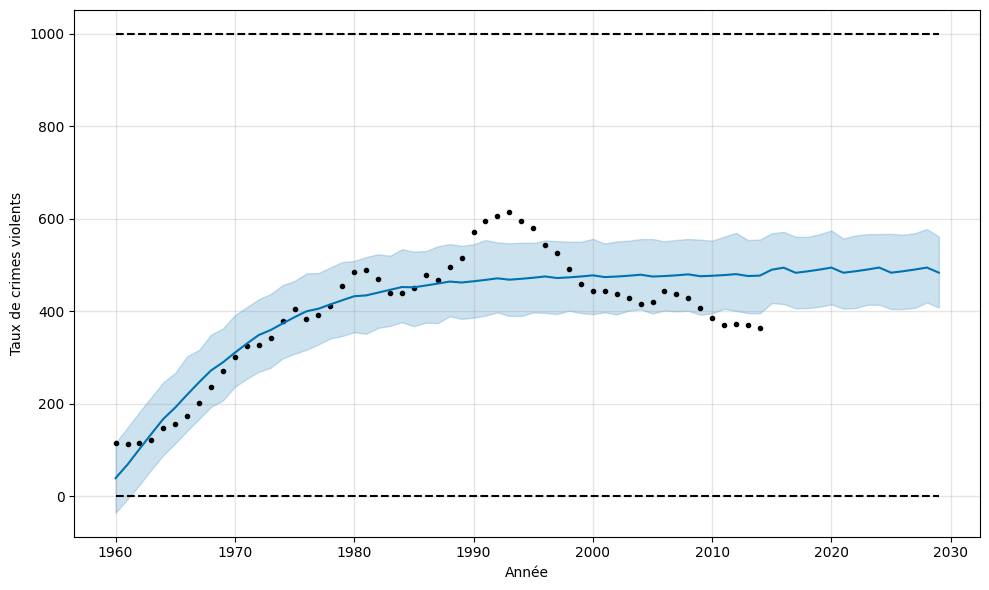

In [ ]:
# Tracé des prédictions
%matplotlib inline
plt.close() # Fermeture de la figure précédente pour en tracer une nouvelle
fig = simple_model.plot(simple_forecast, ylabel='Taux de crimes violents', xlabel='Année')


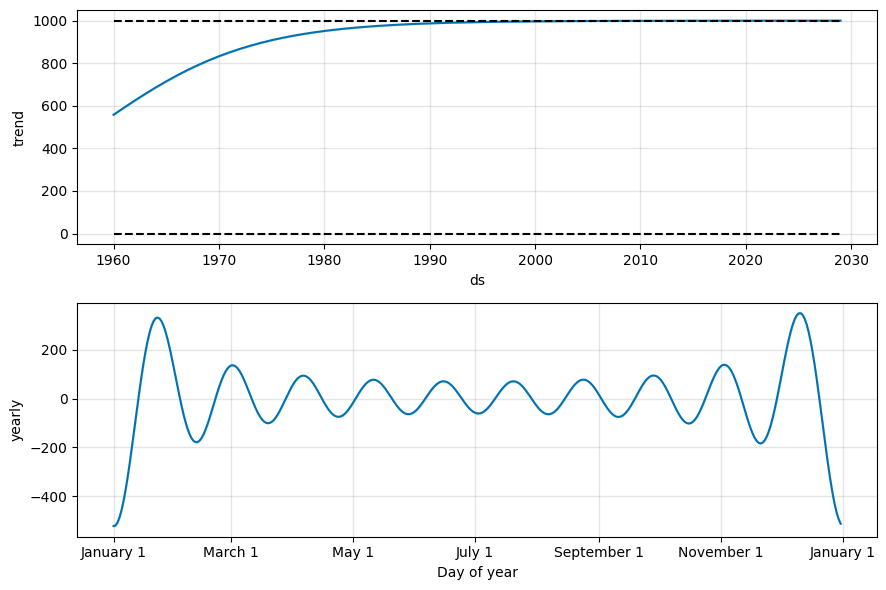

In [ ]:
# Affichage des composantes
plt.close()
fig = simple_model.plot_components(simple_forecast)

Ce modèle n'est pas une grande réussite. La tendance par exemple est très mal captée, et modélisée par une augmentation continue qui ne reflète pas le pic des années 1980.

Plusieurs raisons peuvent être invoquées : la série étudiée n'est pas une série "business", elle est étalée sur de nombreuses années, pas de saisonnalité évidente, etc...

# Complement RNN


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split

In [ ]:
df_rnn = pd.read_csv('crime_transformed.csv', index_col='Year', parse_dates=True, dtype={'state': 'category'})
national_df_rnn = df.groupby('Year').agg({
    'population': 'sum',
    'violent_crime_total': 'sum',
    'murder': 'sum',
    'robbery': 'sum',
    'assault': 'sum',
    'property_crime_total': 'sum',
    'burglary': 'sum',
    'theft': 'sum',
    'car_theft': 'sum',
    'rape': 'sum'
})

national_df_rnn.head()

,population,violent_crime_total,murder,robbery,assault,property_crime_total,burglary,theft,car_theft,rape
Year,,,,,,,,,,
1960-01-01,162540871,5743.3,261.3,1900.6,3179.3,80224.0,21174.4,50819.7,8229.7,402.2
1961-01-01,165923956,5644.5,240.3,1901.1,3118.9,80838.5,21868.1,50614.2,8356.0,383.9
1962-01-01,168418000,5727.6,225.1,1930.4,3177.6,84568.8,22422.8,53144.9,9001.2,395.1
1963-01-01,170825000,6044.1,227.6,2038.6,3385.1,91153.5,24609.3,56678.5,9866.0,392.6
1964-01-01,173419000,7362.1,239.4,2239.5,4398.5,99303.5,27124.8,61429.2,10749.1,485.5


In [ ]:
# Mise à l’échelle
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(national_df_rnn)

# Construction des séquences
n_steps = 2
X, y = [], []
target_idx = national_df_rnn.columns.get_loc("violent_crime_total")

for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i - n_steps:i])
    y.append(scaled_data[i, target_idx])

X, y = np.array(X), np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle RNN simple
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    SimpleRNN(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Entraînement
model.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0055
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0061
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0031
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0022
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0020
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0022
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0018
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0014
Epoch 16/100
2/2 ━━

In [ ]:
# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
MSE : 0.0105
MAE : 0.0777
R²  : -2.3391


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 


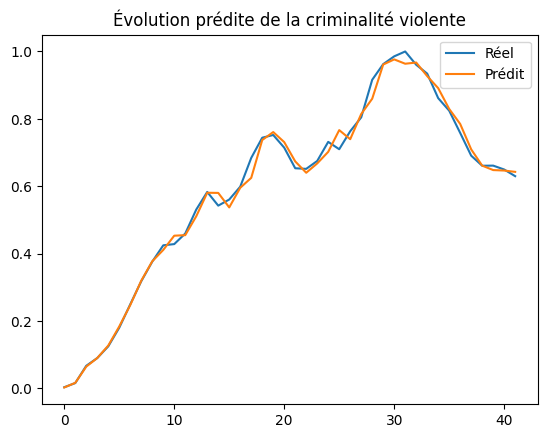

In [ ]:
y_pred_train = model.predict(X_train)

plt.plot(y_train, label='Réel')
plt.plot(y_pred_train, label='Prédit')
plt.legend()
plt.title("Évolution prédite de la criminalité violente")
plt.show()

In [ ]:
y_test_full = np.zeros((y_test.shape[0], national_df_rnn.shape[1]))
y_test_full[:, target_idx] = y_test
y_test_inverse = scaler.inverse_transform(y_test_full)
y_test_original = y_test_inverse[:, target_idx]

y_pred_full = np.zeros((y_pred.shape[0], national_df_rnn.shape[1]))
y_pred_full[:, target_idx] = y_pred[:, 0]
y_pred_inverse = scaler.inverse_transform(y_pred_full)
y_pred_original = y_pred_inverse[:, target_idx]



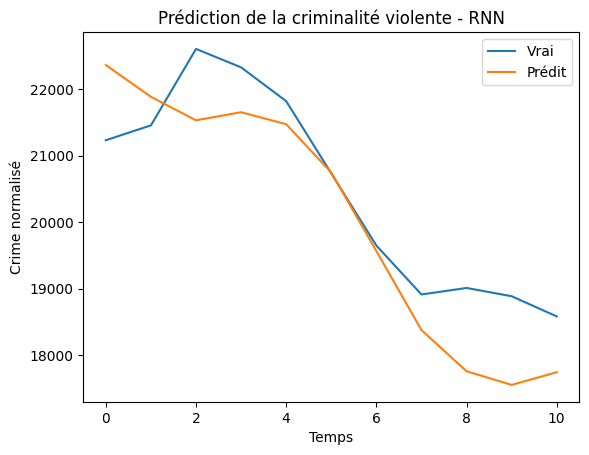

In [ ]:
plt.plot(y_test_original, label='Vrai')
plt.plot(y_pred_original, label='Prédit')
plt.legend()
plt.title("Prédiction de la criminalité violente - RNN")
plt.xlabel("Temps")
plt.ylabel("Crime normalisé")
plt.show()


# Complement LSTN

In [ ]:
# Supposons que ton DataFrame s'appelle df
df = pd.read_csv('crime_transformed.csv', index_col='Year', parse_dates=True, dtype={'state': 'category'})
# df = df[df['state'] == 'Arizona']
# df = df.drop(columns=['state'])
# df.index = pd.to_datetime(df.index)
# df.head()

Agrégation par année (nationalisation)

➤ Objectif : Regrouper tous les États pour chaque année.


In [ ]:
# df['Year'] = pd.to_datetime(df['Year'])

# Agréger par année pour obtenir les totaux/niveaux nationaux
national_df = df.groupby('Year').agg({
    'population': 'sum',
    'violent_crime_total': 'sum',
    'murder': 'sum',
    'robbery': 'sum',
    'assault': 'sum',
    'property_crime_total': 'sum',
    'burglary': 'sum',
    'theft': 'sum',
    'car_theft': 'sum',
    'rape': 'sum'
})

national_df.head()

,population,violent_crime_total,murder,robbery,assault,property_crime_total,burglary,theft,car_theft,rape
Year,,,,,,,,,,
1960-01-01,162540871,5743.3,261.3,1900.6,3179.3,80224.0,21174.4,50819.7,8229.7,402.2
1961-01-01,165923956,5644.5,240.3,1901.1,3118.9,80838.5,21868.1,50614.2,8356.0,383.9
1962-01-01,168418000,5727.6,225.1,1930.4,3177.6,84568.8,22422.8,53144.9,9001.2,395.1
1963-01-01,170825000,6044.1,227.6,2038.6,3385.1,91153.5,24609.3,56678.5,9866.0,392.6
1964-01-01,173419000,7362.1,239.4,2239.5,4398.5,99303.5,27124.8,61429.2,10749.1,485.5


In [ ]:
# Normalisation
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(national_df)

# Fenêtre temporelle : on utilise les n_steps dernières années pour prédire la suivante
n_steps = 2
X, y = [], []
target_idx = df.columns.get_loc("violent_crime_total")

for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i])
    y.append(scaled_data[i, target_idx])

X = np.array(X)
y = np.array(y)

In [ ]:
mean_crime.head()

,ds,y,cap,floor
0,1960-01-01,114.866,1000,0
1,1961-01-01,112.890,1000,0
2,1962-01-01,114.552,1000,0
3,1963-01-01,120.882,1000,0
4,1964-01-01,147.242,1000,0


In [ ]:
split = int(0.8 * len(X))  # 80% entraînement, 20% test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(128, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, verbose=1, callbacks=[early_stop])

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3064
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2404
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1922
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1437
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1037 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0646
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0323
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0128
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0039
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0060
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0137 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0193
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0191
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0159
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0090
Epoch 16/100
2/2 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


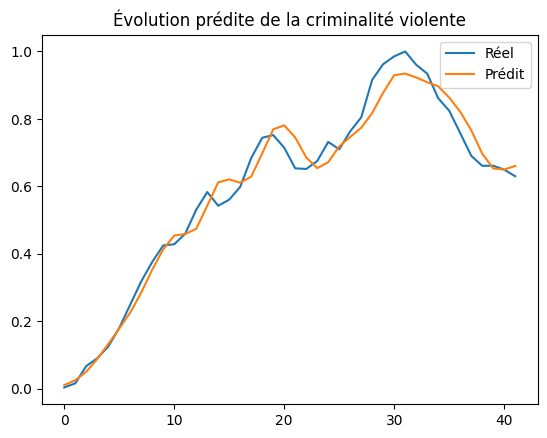

In [ ]:
y_pred_train = model.predict(X_train)

plt.plot(y_train, label='Réel')
plt.plot(y_pred_train, label='Prédit')
plt.legend()
plt.title("Évolution prédite de la criminalité violente")
plt.show()

In [ ]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² : {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Test MSE: 0.0010
Test MAE: 0.0285
Test R² : 0.6758


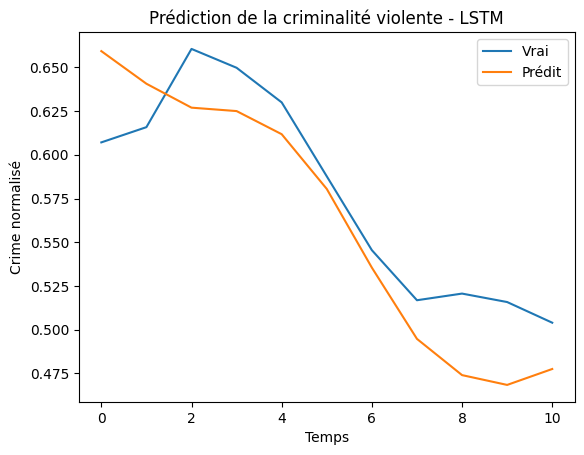

In [ ]:
plt.plot(y_test, label='Vrai')
plt.plot(y_pred, label='Prédit')
plt.legend()
plt.title("Prédiction de la criminalité violente - LSTM")
plt.xlabel("Temps")
plt.ylabel("Crime normalisé")
plt.show()
